## Generate Static Graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = 2021
month = 9
program = "prepilot"
study_type = None

In [2]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
from plots import *
import scaffolding
from uuid import UUID

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

Connecting to database URL db


In [3]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

## Collect Data From Database

In [4]:
tq = scaffolding.get_time_query(year, month)
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)
labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)
expanded_ct = scaffolding.expand_userinputs(labeled_ct)
expanded_ct = scaffolding.data_quality_check(expanded_ct)

[UUID('863e9c6c-8ec0-48c4-b765-3f73d839c85b'),
 UUID('c6e4db31-c18b-4355-b02a-7dd97deca70b'),
 UUID('c6807997-194c-4c52-8a8f-a8c1f6ee1595'),
 UUID('e9e479e9-5c3f-4345-a885-dadb7999b312'),
 UUID('6656c04c-6cba-4c18-9fed-805eaa529741'),
 UUID('9910245f-ee4e-4cca-ab4c-dd2312eb0d5d'),
 UUID('9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98'),
 UUID('509b9093-9093-4e98-8eb1-20b58ed9bd8c'),
 UUID('e192b8a0-0b6c-4222-9685-1c93785deaf7'),
 UUID('2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d'),
 UUID('56e23e21-6152-4f59-9253-50bd28a5d7f9'),
 UUID('840297ae-3948-4e26-bfeb-e83ee30c5b3e'),
 UUID('d7a732f4-a864-4bcb-b8de-dfc8be242fb2'),
 UUID('5ad862e7-9a63-41f6-9f28-c0096fe884da'),
 UUID('21c78a1c-6df2-4097-b289-5a784610991b'),
 UUID('e4cfb2a8-f600-4268-9756-9985e234636e'),
 UUID('fc68a5bb-0a7b-4b63-86b3-f08a69ead36f'),
 UUID('321b7e37-a9a1-4775-9ebb-b5dc88e183fb'),
 UUID('28cb1dde-8551-4bba-bfd4-2145bdaf7e0a'),
 UUID('e35e6510-7a34-496d-b49f-a5a0b41a1e9e'),
 UUID('d3735ba2-12dd-4c76-8e16-75dca7bdcb6f'),
 UUID('97953a

Loaded all confirmed trips of length 11836


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.630502e+09,2021-09-01T07:15:17.000028-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",612f7d247b8bfbc09d1acd26,1.630501e+09,2021-09-01T06:57:24.690419-06:00,"{'type': 'Point', 'coordinates': [-107.8518209...",1072.309608,11851.503432,...,9,1,7,15,17,2,America/Denver,612f7d9d7b8bfbc09d1acd60,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630502e+09
1,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:52:37.999908-06:00,"{'type': 'Point', 'coordinates': [-107.8689998...",612f8b1fe68d63d2fb8d7a1a,1.630504e+09,2021-09-01T07:40:11.520930-06:00,"{'type': 'Point', 'coordinates': [-107.8835057...",746.478978,3711.798398,...,9,1,7,52,37,2,America/Denver,612f8b64e68d63d2fb8d7a49,5ad862e7-9a63-41f6-9f28-c0096fe884da,1.630506e+09
2,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:49:45.606963-06:00,"{'type': 'Point', 'coordinates': [-107.8600675...",612f8b3786733a8f9a900db7,1.630503e+09,2021-09-01T07:35:10.901781-06:00,"{'type': 'Point', 'coordinates': [-107.8720599...",874.705182,10355.326280,...,9,1,7,49,45,2,America/Denver,612f8b6686733a8f9a900df4,c6807997-194c-4c52-8a8f-a8c1f6ee1595,1.630506e+09
3,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:53:28.001725-06:00,"{'type': 'Point', 'coordinates': [-107.8853829...",612f8b2d5f105b1932cef7a8,1.630504e+09,2021-09-01T07:46:08.299580-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",439.702145,2127.880652,...,9,1,7,53,28,2,America/Denver,612f8b8f5f105b1932cef7cd,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630506e+09
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09


After filtering, found 11836 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.630502e+09,2021-09-01T07:15:17.000028-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",612f7d247b8bfbc09d1acd26,1.630501e+09,2021-09-01T06:57:24.690419-06:00,"{'type': 'Point', 'coordinates': [-107.8518209...",1072.309608,11851.503432,...,9,1,7,15,17,2,America/Denver,612f7d9d7b8bfbc09d1acd60,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630502e+09
1,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:52:37.999908-06:00,"{'type': 'Point', 'coordinates': [-107.8689998...",612f8b1fe68d63d2fb8d7a1a,1.630504e+09,2021-09-01T07:40:11.520930-06:00,"{'type': 'Point', 'coordinates': [-107.8835057...",746.478978,3711.798398,...,9,1,7,52,37,2,America/Denver,612f8b64e68d63d2fb8d7a49,5ad862e7-9a63-41f6-9f28-c0096fe884da,1.630506e+09
2,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:49:45.606963-06:00,"{'type': 'Point', 'coordinates': [-107.8600675...",612f8b3786733a8f9a900db7,1.630503e+09,2021-09-01T07:35:10.901781-06:00,"{'type': 'Point', 'coordinates': [-107.8720599...",874.705182,10355.326280,...,9,1,7,49,45,2,America/Denver,612f8b6686733a8f9a900df4,c6807997-194c-4c52-8a8f-a8c1f6ee1595,1.630506e+09
3,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:53:28.001725-06:00,"{'type': 'Point', 'coordinates': [-107.8853829...",612f8b2d5f105b1932cef7a8,1.630504e+09,2021-09-01T07:46:08.299580-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",439.702145,2127.880652,...,9,1,7,53,28,2,America/Denver,612f8b8f5f105b1932cef7cd,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630506e+09
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09


After filtering, found 5458 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09
7,DwellSegmentationTimeFilter,1.630512e+09,2021-09-01T10:07:39.824000-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",612fa723ce8c93ad2e54b60a,1.630511e+09,2021-09-01T09:48:45.703800-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",1134.120200,10998.235798,...,9,1,10,7,39,2,America/Denver,612fa72cce8c93ad2e54b646,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630513e+09
8,DwellSegmentationDistFilter,1.630512e+09,2021-09-01T09:55:54.618285-06:00,"{'type': 'Point', 'coordinates': [-107.8724742...",612fa74132ef04cc63d731fc,1.630510e+09,2021-09-01T09:29:24.795737-06:00,"{'type': 'Point', 'coordinates': [-107.8559166...",1589.822548,5695.277053,...,9,1,9,55,54,2,America/Denver,612fa78b32ef04cc63d73258,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,1.630513e+09
11,DwellSegmentationTimeFilter,1.630514e+09,2021-09-01T10:29:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",612fc32eff291becf892aedd,1.630513e+09,2021-09-01T10:17:37.157156-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",690.842844,1445.210704,...,9,1,10,29,8,2,America/Denver,612fc331ff291becf892af5c,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09
12,DwellSegmentationTimeFilter,1.630516e+09,2021-09-01T11:05:06.885000-06:00,"{'type': 'Point', 'coordinates': [-107.8600612...",612fc32eff291becf892aedf,1.630514e+09,2021-09-01T10:32:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",1978.885000,926.533108,...,9,1,11,5,6,2,America/Denver,612fc331ff291becf892af5d,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09


,mode_confirm,purpose_confirm,replaced_mode
4,drove_alone,home,NaN
7,drove_alone,work,NaN
8,bike,work,bike
11,drove_alone,at_work,NaN
12,drove_alone,work,NaN


After expanding, columns went from 38 -> 41


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09,drove_alone,home,NaN
7,DwellSegmentationTimeFilter,1.630512e+09,2021-09-01T10:07:39.824000-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",612fa723ce8c93ad2e54b60a,1.630511e+09,2021-09-01T09:48:45.703800-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",1134.120200,10998.235798,...,7,39,2,America/Denver,612fa72cce8c93ad2e54b646,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630513e+09,drove_alone,work,NaN
8,DwellSegmentationDistFilter,1.630512e+09,2021-09-01T09:55:54.618285-06:00,"{'type': 'Point', 'coordinates': [-107.8724742...",612fa74132ef04cc63d731fc,1.630510e+09,2021-09-01T09:29:24.795737-06:00,"{'type': 'Point', 'coordinates': [-107.8559166...",1589.822548,5695.277053,...,55,54,2,America/Denver,612fa78b32ef04cc63d73258,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,1.630513e+09,bike,work,bike
11,DwellSegmentationTimeFilter,1.630514e+09,2021-09-01T10:29:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",612fc32eff291becf892aedd,1.630513e+09,2021-09-01T10:17:37.157156-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",690.842844,1445.210704,...,29,8,2,America/Denver,612fc331ff291becf892af5c,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09,drove_alone,at_work,NaN
12,DwellSegmentationTimeFilter,1.630516e+09,2021-09-01T11:05:06.885000-06:00,"{'type': 'Point', 'coordinates': [-107.8600612...",612fc32eff291becf892aedf,1.630514e+09,2021-09-01T10:32:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",1978.885000,926.533108,...,5,6,2,America/Denver,612fc331ff291becf892af5d,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09,drove_alone,work,NaN


In [5]:
# Mapping new labels with dictionaries
expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)

# Mapping fuel
expanded_ct['Mode_confirm_fuel']= expanded_ct['Mode_confirm'].map(dic_fuel)
expanded_ct['Replaced_mode_fuel']= expanded_ct['Replaced_mode'].map(dic_fuel)

# Change meters to miles
scaffolding.unit_conversions(expanded_ct)

# Calculate energy impact
expanded_ct = scaffolding.energy_intensity(expanded_ct, df_ei, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')

In [6]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_2021_09_prepilot
Based on 5458 confirmed trips from 90 users
of 11836 total trips from 123 users (46.11%)


## Distribution of Mode_confirm Attribute

,vals,pct
Pilot ebike,1869,34.243313
"Car, with others",1176,21.546354
"Car, drove alone",939,17.204104
Walk,830,15.207036
Regular Bike,202,3.700989
Not a Trip,148,2.711616
Bus,145,2.656651
Other,97,1.777208
Taxi/Uber/Lyft,28,0.513008
Train,11,0.201539


,vals,pct
Pilot ebike,1869,34.243313
"Car, with others",1176,21.546354
"Car, drove alone",939,17.204104
Walk,830,15.207036
Regular Bike,202,3.700989
Not a Trip,148,2.711616
Bus,145,2.656651


,vals,pct
Pilot ebike,1869.0,34.243313
"Car, with others",1176.0,21.546354
"Car, drove alone",939.0,17.204104
Walk,830.0,15.207036
Regular Bike,202.0,3.700989
Not a Trip,148.0,2.711616
Bus,145.0,2.656651
Other,149.0,2.729938


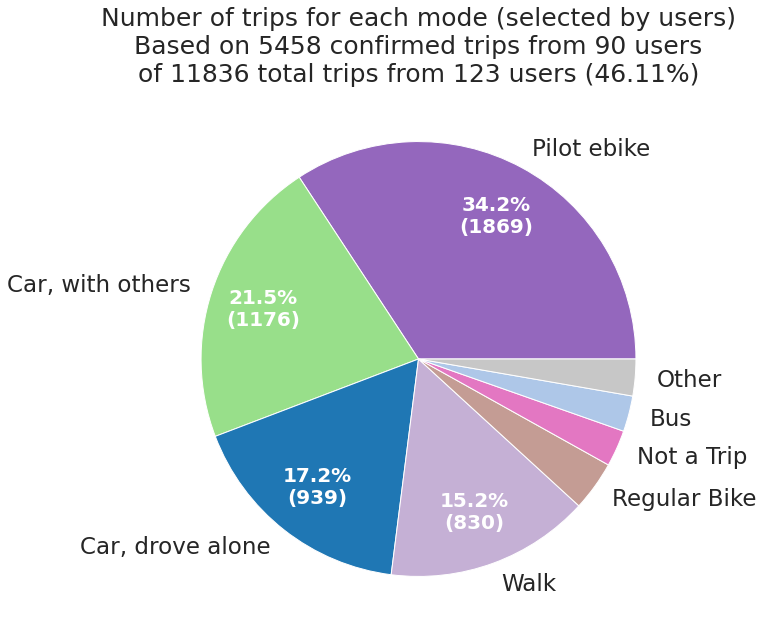

Pilot ebike         1869
Car, with others    1176
Car, drove alone     939
Walk                 830
Regular Bike         202
Not a Trip           148
Bus                  145
Other                 97
Taxi/Uber/Lyft        28
Train                 11
Bikeshare              7
Free Shuttle           5
Scooter share          1
Name: Mode_confirm, dtype: int64


In [7]:
labels_mc = expanded_ct['Mode_confirm'].value_counts(dropna=True).keys().tolist()
values_mc = expanded_ct['Mode_confirm'].value_counts(dropna=True).tolist()
plot_title= "Number of trips for each mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_mc,values_mc,file_name)
print(expanded_ct['Mode_confirm'].value_counts(dropna=True))

,vals,pct
Pilot ebike,611,62.474438
"Car, drove alone",159,16.257669
Walk,90,9.202454
"Car, with others",54,5.521472
Bus,26,2.658487
Regular Bike,15,1.533742
Other,12,1.226994
Not a Trip,6,0.613497
Bikeshare,3,0.306748
Taxi/Uber/Lyft,2,0.204499


,vals,pct
Pilot ebike,611,62.474438
"Car, drove alone",159,16.257669
Walk,90,9.202454
"Car, with others",54,5.521472
Bus,26,2.658487


,vals,pct
Pilot ebike,611.0,62.474438
"Car, drove alone",159.0,16.257669
Walk,90.0,9.202454
"Car, with others",54.0,5.521472
Bus,26.0,2.658487
Other,38.0,3.885481


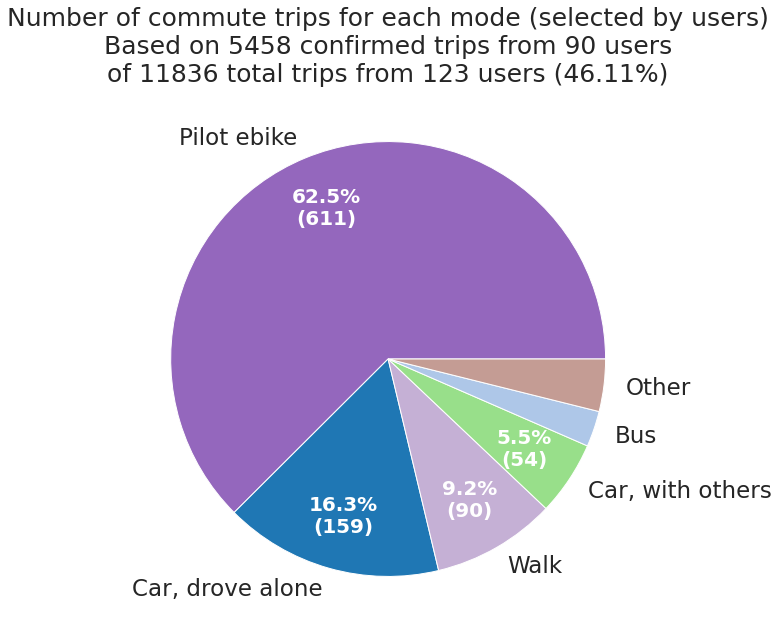

Pilot ebike         611
Car, drove alone    159
Walk                 90
Car, with others     54
Bus                  26
Regular Bike         15
Other                12
Not a Trip            6
Bikeshare             3
Taxi/Uber/Lyft        2
Name: Mode_confirm, dtype: int64


In [8]:
labels_mc = expanded_ct.query("Trip_purpose == 'Work'").Mode_confirm.value_counts(dropna=True).keys().tolist()
values_mc = expanded_ct.query("Trip_purpose == 'Work'").Mode_confirm.value_counts(dropna=True).tolist()
plot_title= "Number of commute trips for each mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_commute_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_mc,values_mc,file_name)
print(expanded_ct.query("Trip_purpose == 'Work'").Mode_confirm.value_counts(dropna=True))

## Distribution of Replace_Mode Attribute

,vals,pct
"Car, drove alone",1468,26.896299
No Travel,1254,22.975449
Walk,659,12.074020
"Car, with others",580,10.626603
Regular Bike,544,9.967021
Other,461,8.446317
Taxi/Uber/Lyft,257,4.708684
Bus,203,3.719311
Bikeshare,11,0.201539
Train,9,0.164896


,vals,pct
"Car, drove alone",1468,26.896299
No Travel,1254,22.975449
Walk,659,12.074020
"Car, with others",580,10.626603
Regular Bike,544,9.967021
Other,461,8.446317
Taxi/Uber/Lyft,257,4.708684
Bus,203,3.719311


,vals,pct
"Car, drove alone",1468.0,26.896299
No Travel,1254.0,22.975449
Walk,659.0,12.074020
"Car, with others",580.0,10.626603
Regular Bike,544.0,9.967021
Other,493.0,9.032613
Taxi/Uber/Lyft,257.0,4.708684
Bus,203.0,3.719311


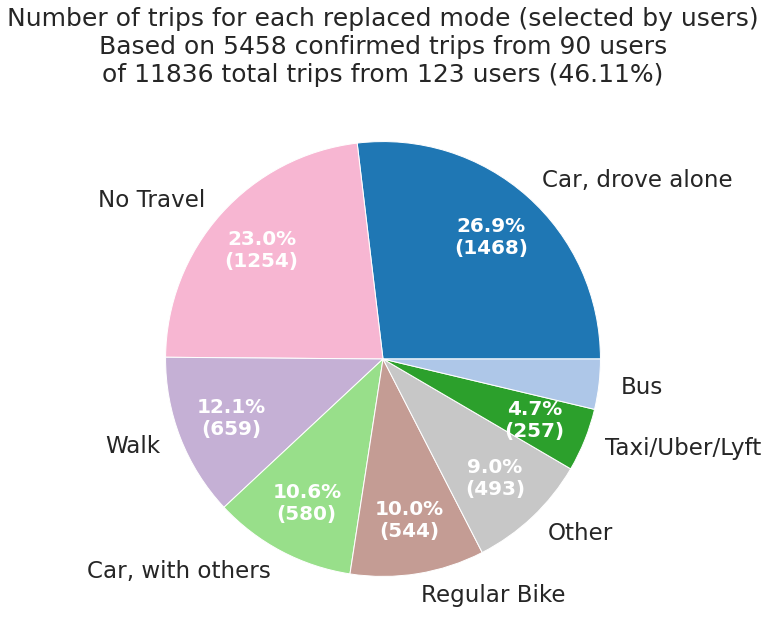

In [9]:
labels_rm = expanded_ct['Replaced_mode'].value_counts(dropna=True).keys().tolist()
values_rm = expanded_ct['Replaced_mode'].value_counts(dropna=True).tolist()
plot_title="Number of trips for each replaced mode (selected by users)\n%s" % quality_text
file_name= 'ntrips_replaced_mode%s.png' % file_suffix
pie_chart_mode(plot_title,labels_rm,values_rm,file_name)

### Note: The portion of pilot ebikes in the pie chart above is only when the mode_confirm is different that ebike. Example: mode_confirm was Walk, replaced_mode ebike. 
###           mode_confrim was Car, drove alone, replaced_mode ebike.

In [10]:
expanded_ct.loc[expanded_ct['Replaced_mode'] == 'Pilot ebike'].Mode_confirm.unique()

array([], dtype=object)

## Distribution of Trip Purpose Attribute

,vals,pct
Other,1272,23.305240
Home,1092,20.007329
Work,978,17.918652
Recreation/Exercise,490,8.977647
Shopping,486,8.904361
Entertainment/Social,406,7.438622
Meal,293,5.368267
Personal/Medical,223,4.085746
School,117,2.143642
Transit transfer,43,0.787834


,vals,pct
Other,1272,23.305240
Home,1092,20.007329
Work,978,17.918652
Recreation/Exercise,490,8.977647
Shopping,486,8.904361
Entertainment/Social,406,7.438622
Meal,293,5.368267
Personal/Medical,223,4.085746
School,117,2.143642


,vals,pct
Other,1373.0,25.155735
Home,1092.0,20.007329
Work,978.0,17.918652
Recreation/Exercise,490.0,8.977647
Shopping,486.0,8.904361
Entertainment/Social,406.0,7.438622
Meal,293.0,5.368267
Personal/Medical,223.0,4.085746
School,117.0,2.143642


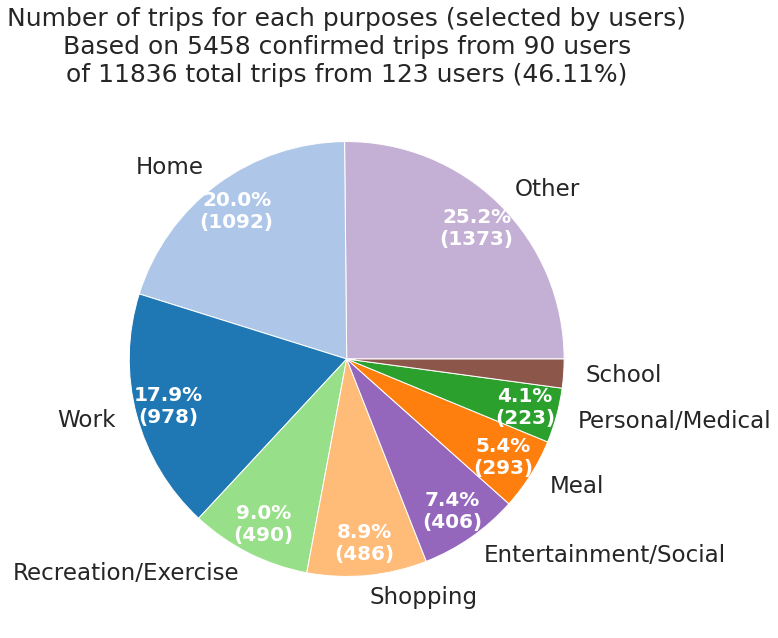

Other                   1272
Home                    1092
Work                     978
Recreation/Exercise      490
Shopping                 486
Entertainment/Social     406
Meal                     293
Personal/Medical         223
School                   117
Transit transfer          43
Religious                 28
not_a_trip                20
Pick-up/Drop off          10
Name: Trip_purpose, dtype: int64


In [11]:
labels_tp = expanded_ct['Trip_purpose'].value_counts(dropna=True).keys().tolist()
values_tp = expanded_ct['Trip_purpose'].value_counts(dropna=True).tolist()
plot_title="Number of trips for each purposes (selected by users)\n%s" % quality_text
file_name= 'ntrips_purpose%s.png' % file_suffix
pie_chart_purpose(plot_title,labels_tp,values_tp,file_name)
print(expanded_ct['Trip_purpose'].value_counts(dropna=True))

## Transport of Choice for Trips Under 10 Miles

,vals,pct
Pilot ebike,1798,37.693920
"Car, with others",871,18.259958
Walk,817,17.127883
"Car, drove alone",731,15.324948
Regular Bike,193,4.046122
Not a Trip,135,2.830189
Bus,106,2.222222
Other,76,1.593291
Taxi/Uber/Lyft,26,0.545073
Bikeshare,7,0.146751


,vals,pct
Pilot ebike,1798,37.693920
"Car, with others",871,18.259958
Walk,817,17.127883
"Car, drove alone",731,15.324948
Regular Bike,193,4.046122
Not a Trip,135,2.830189
Bus,106,2.222222


,vals,pct
Pilot ebike,1798.0,37.693920
"Car, with others",871.0,18.259958
Walk,817.0,17.127883
"Car, drove alone",731.0,15.324948
Regular Bike,193.0,4.046122
Not a Trip,135.0,2.830189
Bus,106.0,2.222222
Other,119.0,2.494759


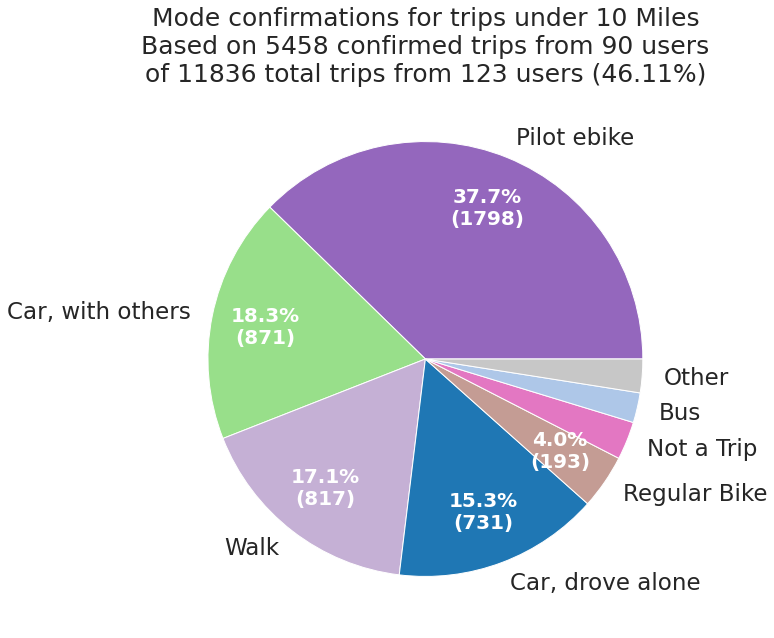

Pilot ebike         1798
Car, with others     871
Walk                 817
Car, drove alone     731
Regular Bike         193
Not a Trip           135
Bus                  106
Other                 76
Taxi/Uber/Lyft        26
Bikeshare              7
Free Shuttle           5
Train                  4
Scooter share          1
Name: Mode_confirm, dtype: int64


In [12]:
labels_d10 = expanded_ct.loc[(expanded_ct['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True).keys().tolist()
values_d10 = expanded_ct.loc[(expanded_ct['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True).tolist()
plot_title="Mode confirmations for trips under 10 Miles\n%s" % quality_text
file_name ='ntrips_under10miles_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_d10,values_d10,file_name)
print(expanded_ct.loc[(expanded_ct['distance_miles'] <= 10)].Mode_confirm.value_counts(dropna=True))

## Miles per transport mode selected (Mode_confirm)

,vals,pct
Other,20660.722668,39.816654
"Car, with others",13500.704963,26.018107
"Car, drove alone",7362.520821,14.188804
Pilot ebike,5274.369321,10.164588
Bus,1809.486397,3.487182
Walk,1621.167779,3.124260
Not a Trip,521.452755,1.004926
Regular Bike,508.644673,0.980243
Train,467.703776,0.901343
Taxi/Uber/Lyft,130.857019,0.252183


,vals,pct
Other,20660.722668,39.816654
"Car, with others",13500.704963,26.018107
"Car, drove alone",7362.520821,14.188804
Pilot ebike,5274.369321,10.164588
Bus,1809.486397,3.487182
Walk,1621.167779,3.124260


,vals,pct
Other,22321.401203,43.017058
"Car, with others",13500.704963,26.018107
"Car, drove alone",7362.520821,14.188804
Pilot ebike,5274.369321,10.164588
Bus,1809.486397,3.487182
Walk,1621.167779,3.124260


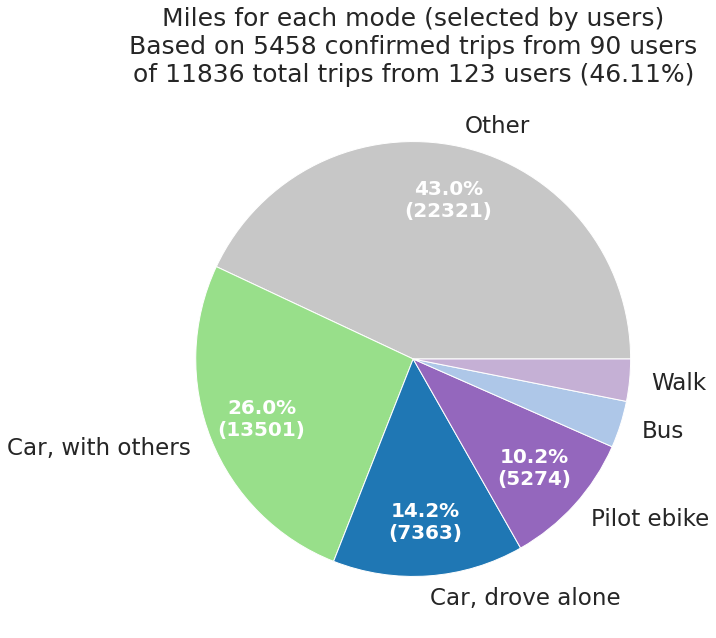

        Mode_confirm  Total (miles)  Count  Average (miles)
6              Other   20660.722668     97       212.997141
3   Car, with others   13500.704963   1176        11.480191
2   Car, drove alone    7362.520821    939         7.840810
7        Pilot ebike    5274.369321   1869         2.822027
1                Bus    1809.486397    145        12.479217
12              Walk    1621.167779    830         1.953214
5         Not a Trip     521.452755    148         3.523329
8       Regular Bike     508.644673    202         2.518043
11             Train     467.703776     11        42.518525
10    Taxi/Uber/Lyft     130.857019     28         4.673465
0          Bikeshare      18.506014      7         2.643716
4       Free Shuttle       9.953464      5         1.990693
9      Scooter share       3.560835      1         3.560835


In [13]:
miles = expanded_ct.groupby('Mode_confirm').agg({'distance_miles': ['sum', 'count' , 'mean']})
miles.columns = ['Total (miles)', 'Count', 'Average (miles)']
miles = miles.reset_index()
miles =miles.sort_values(by=['Total (miles)'], ascending=False)

#data
miles_dict = dict(zip(miles['Mode_confirm'], miles['Total (miles)']))

labels_m = []
values_m = []

for x, y in miles_dict.items():
    labels_m.append(x)
    values_m.append(y)

plot_title="Miles for each mode (selected by users)\n%s" % quality_text
file_name ='miles_mode_confirm%s.png' % file_suffix
pie_chart_mode(plot_title,labels_m,values_m,file_name)
print(miles)

## Average Miles per transport mode selected (Mode_confirm)

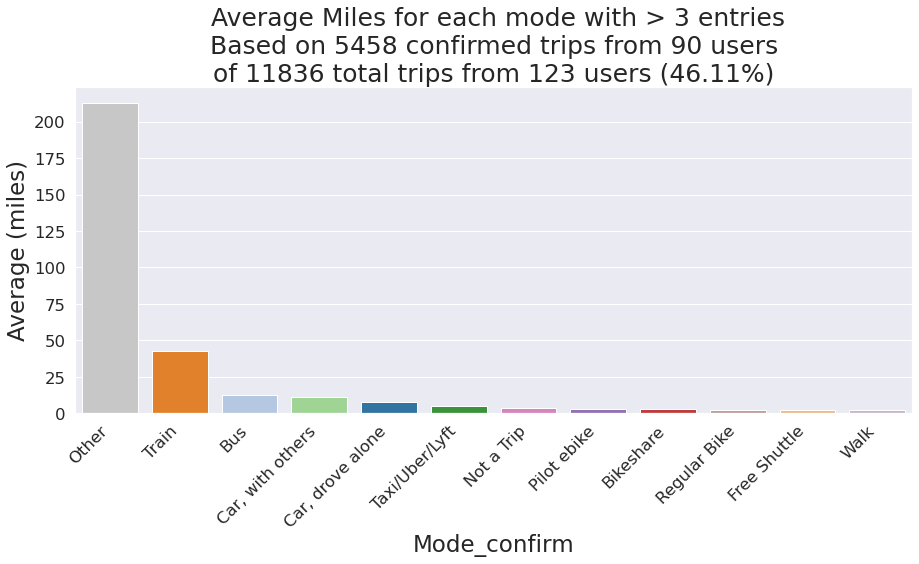

In [14]:
data = miles.drop((miles.query("Count < 3").index)).sort_values(by=['Average (miles)'], ascending=False)
x='Mode_confirm'
y='Average (miles)'

plot_title=" Average Miles for each mode with > 3 entries\n%s" % quality_text
file_name ='average_miles_mode_confirm%s.png' % file_suffix

barplot_mode(data,x,y,plot_title,file_name)

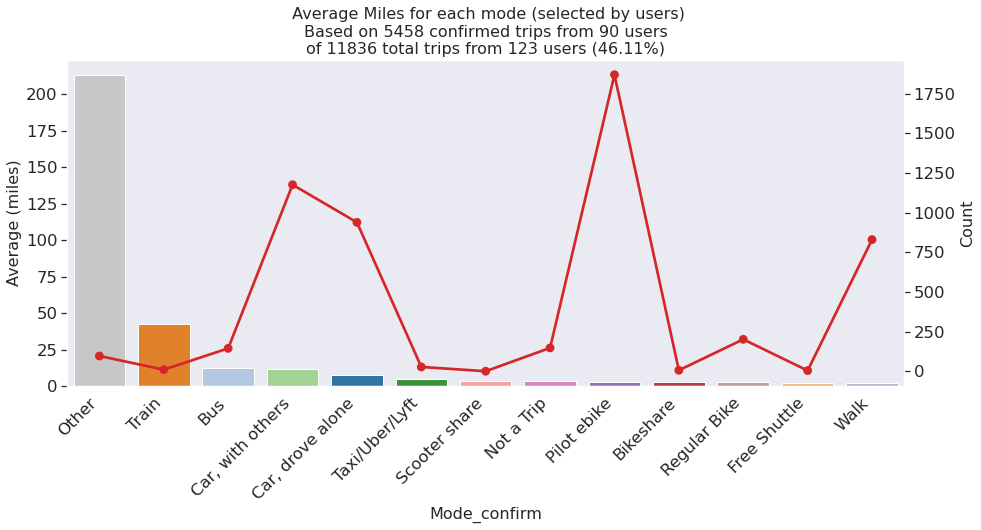

In [15]:
data = miles.sort_values(by=['Average (miles)'], ascending=False)
x='Mode_confirm'
y='Average (miles)'
y2 = "Count"

plot_title=" Average Miles for each mode (selected by users)\n%s" % quality_text
file_name ='average_miles_mode_confirm2%s.png' % file_suffix

barplot_mode2(data,x,y,y2,plot_title,file_name)

## Number of Trips by Day¶

In [16]:
fq_days = expanded_ct.groupby(['start_local_dt_day']).agg({'start_local_dt_day': ['sum', 'count']})
fq_days = fq_days.reset_index()
fq_days.columns = ['Day of the Month', 'Total', 'Number of Trips']
fq_days

,Day of the Month,Total,Number of Trips
0,1,153,153
1,2,360,180
2,3,588,196
3,4,696,174
4,5,815,163
5,6,966,161
6,7,1344,192
7,8,1440,180
8,9,1980,220
9,10,1940,194


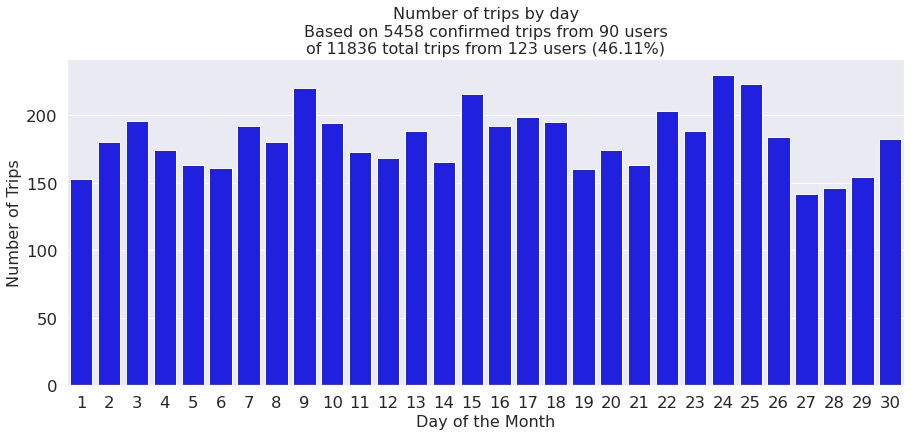

In [17]:
data = fq_days
x = 'Day of the Month'
y = 'Number of Trips'

plot_title="Number of trips by day\n%s" % quality_text
file_name ='ntrips_per_day%s.png' % file_suffix

barplot_day(data,x,y,plot_title,file_name)

## Number of Trips by day of week¶

In [18]:
fq_weekdays = expanded_ct.groupby(['start_local_dt_weekday']).agg({'start_local_dt_weekday': ['sum', 'count']})
fq_weekdays = fq_weekdays.reset_index()
fq_weekdays.columns = ['Weekday', 'Total', 'Number of Trips']
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
fq_weekdays["Weekday"] = fq_weekdays.Weekday.apply(lambda x: weekday_labels[x])
fq_weekdays

,Weekday,Total,Number of Trips
0,Mon,0,665
1,Tue,666,666
2,Wed,1812,906
3,Thu,2886,962
4,Fri,3276,819
5,Sat,3825,765
6,Sun,4050,675


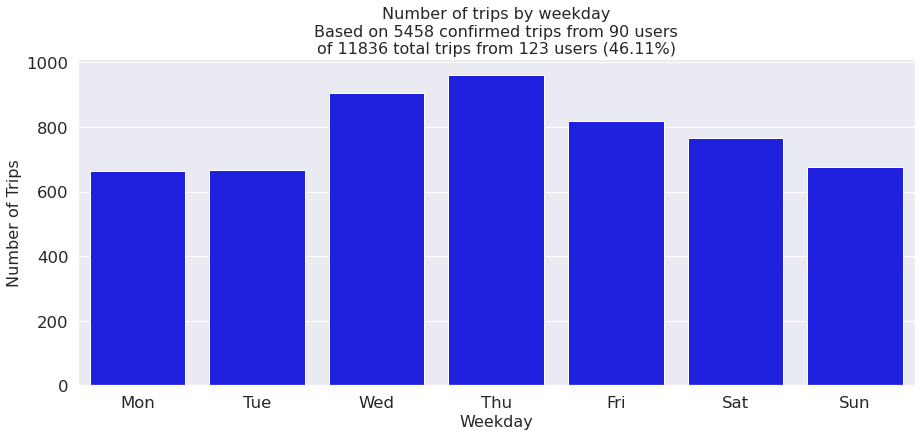

In [19]:
data = fq_weekdays
x = 'Weekday'
y = 'Number of Trips'

plot_title="Number of trips by weekday\n%s" % quality_text
file_name ='ntrips_per_weekday%s.png' % file_suffix

barplot_day(data,x,y,plot_title,file_name)